In [1]:
# Overview
############
# This end-to-end walkthrough trains a logistic regression 
# model using the (tf.estimator) API.
# The model is often used as a baseline for other, more complex,
# algorithms.

In [49]:
# Setup
#############
from __future__ import absolute_import, print_function, division, unicode_literals

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
tf.enable_eager_execution()

ValueError: tf.enable_eager_execution must be called at program startup.

In [6]:
# Load the Titanic Dataset
######################
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [23]:
# Load dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [24]:
# Explore the data
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [25]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [26]:
# There are 627 and 264 examples in 
# the training and evaluation sets, respectively.
dftrain.shape[0], dfeval.shape[0]

(627, 264)

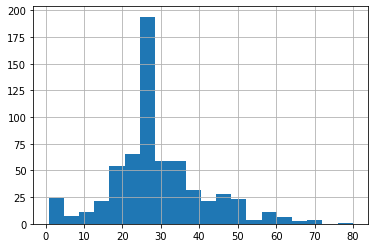

In [28]:
# The majority of passengers are in their 20's and 30's
dftrain.age.hist(bins=20)

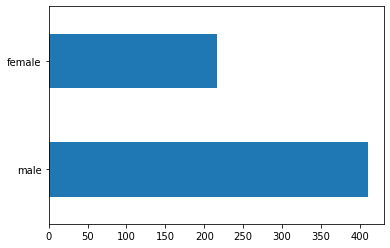

In [29]:
# There are approximately twice as many male passengers as
# female passengers aboard
dftrain.sex.value_counts().plot(kind='barh')

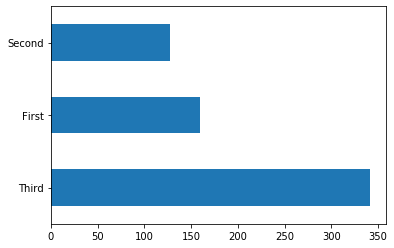

In [30]:
# The majority of passengers were in the "third" class
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

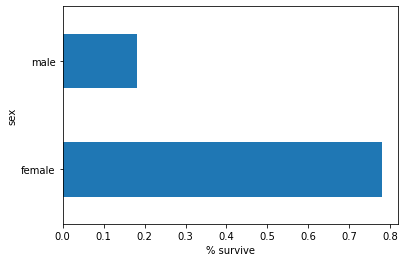

In [40]:
# Females have a much higher chance of surviving versus males.
# This is clearly a predictive feature for the model.
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')


In [42]:
# Feature Engineering for the model
#########################################
# nb. The linear estimator uses both numeric and categorical
# features
# Feature columns provide some feature engineering capabilities
# like, one-hot-encoding, normalization, and bucketization

# Base Feature Columns
CATEGORICAL_COLUMNS = [
    'sex','n_siblings_spouses','parch','class','deck',
    'embark_town','alone'
]
NUMERIC_COLUMNS = ['age','fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(
        tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocabulary)
    )
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(
        tf.feature_column.numeric_column(feature_name, dtype=tf.float32)
    )
    
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

In [44]:
# The (input_function) specifies how data is converted to a
# (tf.data.Dataset) that feeds the input pipeline in a
# fashion streaming.
# (tf.data.Dataset) take take in multiple sources such as 
# dataframe, a csv-formatted file, and more

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if(shuffle):
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [47]:
# INSPECT THE DATASET
###################
ds = make_input_fn(dftrain,y_train,batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['class'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']



AttributeError: 'Tensor' object has no attribute 'numpy'

In [48]:
# Yo can also inspect the result of a specific feature column
# using the (tf.keras.layers.DenseFeatures) layer
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

AttributeError: 'Tensor' object has no attribute 'numpy'

In [51]:
# (DenseFeatures) only accepts dense tensors, to inspect a
# categorical column you need to transform that to a 
# indicator column first
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures(
    [tf.feature_column.indicator_column(gender_column)]
)(feature_batch).numpy()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


AttributeError: 'Tensor' object has no attribute 'numpy'

In [52]:
# After adding all the base features to the model,
# lets train
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)


{'accuracy': 0.77272725, 'accuracy_baseline': 0.625, 'auc': 0.8432814, 'auc_precision_recall': 0.7953886, 'average_loss': 0.46203092, 'label/mean': 0.375, 'loss': 13.552907, 'precision': 0.7010309, 'prediction/mean': 0.36874092, 'recall': 0.68686867, 'global_step': 200}


In [53]:
# DERIVED FEATURE COLUMNS
###########################
age_x_gender = tf.feature_column.crossed_column(
    ['age','sex'],
    hash_bucket_size=100
)
age_x_gender

CrossedColumn(keys=('age', 'sex'), hash_bucket_size=100, hash_key=None)

In [54]:
# After adding the combination feature to the model lets train
# the model again
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(
    feature_columns=feature_columns+derived_feature_columns
)

linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.79545456, 'accuracy_baseline': 0.625, 'auc': 0.8550352, 'auc_precision_recall': 0.78070927, 'average_loss': 0.45408338, 'label/mean': 0.375, 'loss': 13.319779, 'precision': 0.72727275, 'prediction/mean': 0.36982825, 'recall': 0.72727275, 'global_step': 200}


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp3ale6thj/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


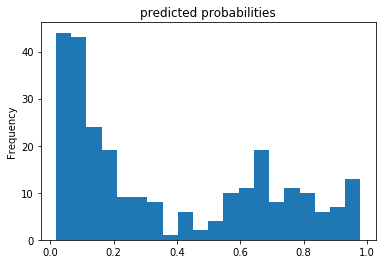

In [55]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0, 1.05)

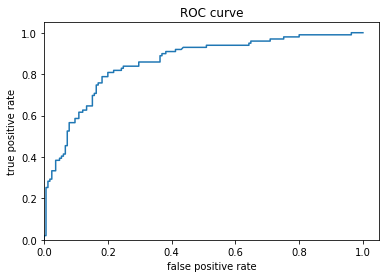

In [56]:
# Finally, look at the receiver operating characteristic (ROC) 
# of the results, which will give us a better idea of the 
# tradeoff between the true positive rate and false positive 
# rate.

from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr,_ = roc_curve(y_eval,probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)